### Read and Split Data

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

df = pd.read_csv('./datasets/train.csv')
df

,Id,Popularity,Page content
0,0,-1,"<html><head><div class=""article-info""> <span c..."
1,1,1,"<html><head><div class=""article-info""><span cl..."
2,2,1,"<html><head><div class=""article-info""><span cl..."
3,3,-1,"<html><head><div class=""article-info""><span cl..."
4,4,-1,"<html><head><div class=""article-info""><span cl..."
...,...,...,...
27638,27638,-1,"<html><head><div class=""article-info""><span cl..."
27639,27639,-1,"<html><head><div class=""article-info""><span cl..."
27640,27640,-1,"<html><head><div class=""article-info""><span cl..."
27641,27641,-1,"<html><head><div class=""article-info""><span cl..."


In [3]:
df.groupby('Popularity').size()

Popularity
-1    14011
 1    13632
dtype: int64

In [4]:
X = df.loc[:, 'Page content'].to_numpy()
y = df.loc[:,'Popularity'].to_numpy()
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=1224)

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
y_train

(22114,) (22114,)
(5529,) (5529,)


array([-1,  1,  1, ...,  1,  1, -1], dtype=int64)

In [9]:
print((y_train == -1).sum(), (y_train == 1).sum())
print((y_valid == -1).sum(), (y_valid == 1).sum())

11246 10868
2765 2764


### Feature Engineering

In [5]:
import os

POSITIVE_WORDS = os.path.join(os.getcwd(), 'datasets', 'positive-words.txt')
NEGATIVE_WORDS = os.path.join(os.getcwd(), 'datasets', 'negative-words.txt')
pos_words = []
neg_words = []


for line in open(POSITIVE_WORDS, 'r').readlines()[35:]:
    word = line.rstrip()
    pos_words.append(word)

for line in open(NEGATIVE_WORDS, 'r').readlines()[35:]:
    word = line.rstrip()
    neg_words.append(word)

In [3]:
print(len(pos_words))
print(len(neg_words))

2006
4783


In [6]:
import re
from bs4 import BeautifulSoup

def preprocessor(text):
    # remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # regex for matching emoticons, keep emoticons, ex: :), :-P, :-D
    r = r'(?::|;|=|X)(?:-)?(?:\)|\(|D|P)'
    emoticons = re.findall(r, text)
    text = re.sub(r, '', text)

    # convert to lowercase and append all emoticons behind (with space in between)
    # replace('-','') removes nose of emoticons
    text = re.sub(r'[\W]+', ' ', text.lower()) + ' ' + ' '.join(emoticons).replace('-','')
    return text

In [10]:
preprocessor(X[0])

' clara moskowitz for space com 2013 06 19 15 04 30 utc nasa s grand challenge stop asteroids from destroying earth there may be killer asteroids headed for earth and nasa has decided to do something about it the space agency announced a new grand challenge on june 18 to find all dangerous space rocks and figure out how to stop them from destroying our planet the new mission builds on projects already underway at nasa including a plan to capture an asteroid pull it in toward the moon and send astronauts to visit it as part of the grand challenge the agency issued a request for information today aiming to solicit ideas from industry academia and the public on how to improve the asteroid mission plan we re asking for you to think about concepts and different approaches for what we ve described here william gerstenmaier nasa s associate administrator for human explorations and operations said yesterday during a nasa event announcing the initiative we want you to think about other ways of 

In [4]:
from collections import Counter
from string import punctuation
import re
from bs4 import BeautifulSoup

soup = BeautifulSoup(X[70], 'html.parser')
# print(soup.prettify())

# Title
print("Title: ", soup.find("h1", {"class": "title"}).text)

# Channel
print("Data Channel: ", soup.find("article").get("data-channel"))

# Author
author_re = r'(By\s|^)(.*?)(?=\d{4}-\d{2}-\d{2}|$)'
if soup.head.find("span") == None:
    print("Author: None")
else:
    print("Author: ", re.search(author_re, soup.head.find("span").text).group(1))

# Related Topics
print("Topics: ", soup.find("footer", {"class": 'article-topics'}).text.replace(" Topics: ", "").split(","))

# Time
print("Time: ", re.search(r'(\d+:\d+:\d+)', soup.time.text).group(1)[:5])

# Weekend
print("Weekend: ", int(soup.time.get("datetime")[:3] in ["Sat", "Sun"]))

# Word Count
text_p = (''.join(s.findAll(string=True))for s in soup.findAll('p'))
c_p = Counter((x.rstrip(punctuation).lower() for y in text_p for x in y.split()))
text_div = (''.join(s.findAll(string=True))for s in soup.findAll('div'))
c_div = Counter((x.rstrip(punctuation).lower() for y in text_div for x in y.split()))
total = c_div + c_p
print("Total words: ", len(list(total.elements())))


section = soup.find("section", {"class": "article-content"})

# Video + Image count
img_count = len(section.find_all("img")) + len(section.find_all("picture")) + len(section.find_all("figure"))
video_count = len(section.find_all("video")) + len(section.find_all("iframe"))
media_count = img_count + video_count
print("Media count: ", media_count)

# Appealing count
link_count = len(section.find_all("a"))
strong_count = len(section.find_all("strong"))
appealing_count = link_count + strong_count
print("Link count: ", appealing_count)

NameError: name 'X' is not defined

In [7]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.lancaster import LancasterStemmer

# nltk.download('stopwords')
stop = stopwords.words('english')

def tokenizer_stem_neg(text):
    stemmer = LancasterStemmer()
    return [stemmer.stem(w) for w in re.split(r'\s+', text.strip()) \
            if w in neg_words and re.match('[a-zA-Z]+', w)]

def tokenizer_stem_pos(text):
    stemmer = LancasterStemmer()
    return [stemmer.stem(w) for w in re.split(r'\s+', text.strip()) \
            if w in pos_words and re.match('[a-zA-Z]+', w)]

### feature selection

In [8]:
from collections import Counter
from string import punctuation
import re
from bs4 import BeautifulSoup

def feature_selection(data):
    feature_str = ""
    soup = BeautifulSoup(data, 'html.parser')

    # Title
    feature_str += soup.find("h1", {"class": "title"}).text + " "

    # Channel
    feature_str += soup.find("article").get("data-channel") + " "

    # Author
    author_re = r'(?:By\s|by\s)?([a-zA-Z]+(\s[A-Z][a-z]+)*)'
    if soup.head.find("span") != None:
        author = re.search(author_re, soup.head.find("span").text).group(1)
        feature_str += author.split(" ")[-1] + " "

    # Related Topics
    feature_str += soup.find("footer", {"class": 'article-topics'}).text.replace(" Topics: ", "").replace(",", "")

    # Time
    if soup.time.text == None or soup.time.text == "":
        feature_str += "0"
    else:
        hour = int(re.search(r'(\d+:\d+:\d+)', soup.time.text).group(1)[:5].split(":")[0])
        minute = int(re.search(r'(\d+:\d+:\d+)', soup.time.text).group(1)[:5].split(":")[1])
        if hour * 60 + minute < 540:
            feature_str += "morning "
        elif hour * 60 + minute < 720:
            feature_str += "noon "
        elif hour * 60 + minute < 1020:
            feature_str += "afternoon "
        else:
            feature_str += "night "

    # Weekend
    if soup.time.text == None or soup.time.text == "":
        feature_str += "weekday "
    else:
        feature_str += "weekend " if soup.time.get("datetime")[:3] in ["Sat", "Sun"] else "weekday "

    # Word Count
    text_p = (''.join(s.findAll(string=True))for s in soup.findAll('p'))
    c_p = Counter((x.rstrip(punctuation).lower() for y in text_p for x in y.split()))
    text_div = (''.join(s.findAll(string=True))for s in soup.findAll('div'))
    c_div = Counter((x.rstrip(punctuation).lower() for y in text_div for x in y.split()))
    total = c_div + c_p
    if len(list(total.elements())) < 305:
        feature_str += 'wordshort '
    elif len(list(total.elements())) < 600:
        feature_str += 'wordmedium '
    else:
        feature_str += 'wordlong '


    section = soup.find("section", {"class": "article-content"})

    # Video + Image count
    img_count = len(section.find_all("img")) + len(section.find_all("picture")) + len(section.find_all("figure"))
    video_count = len(section.find_all("video")) + len(section.find_all("iframe"))
    media_count = img_count + video_count
    if media_count < 2:
        feature_str += "nomedia "
    elif media_count < 6:
        feature_str += "fewmedia "
    elif media_count < 12:
        feature_str += "somemedia "
    else:
        feature_str += "manymedia "

    # Appealing count
    link_count = len(section.find_all("a"))
    strong_count = len(section.find_all("strong"))
    appealing_count = link_count + strong_count
    if appealing_count < 6:
        feature_str += "appealshort "
    elif appealing_count < 12:
        feature_str += "appealmedium "
    else:
        feature_str += "appeallong "

    # POS & NEG count
    paragraph = section.find_all("p")
    pos_count = 0
    for tag in paragraph:
        pos_count += len(tokenizer_stem_pos(tag.text))
        for word in tokenizer_stem_pos(tag.text):
            feature_str += word + " "


    neg_count = 0
    for tag in paragraph:
        neg_count += len(tokenizer_stem_neg(tag.text))
        for word in tokenizer_stem_neg(tag.text):
            feature_str += word + " "
    

    feature_str = re.sub(r'[,.:\']+', '', feature_str.lower())
    return feature_str

print(feature_selection(X[70]))

senior employees are a firms biggest cybersecurity weakness business business small business startups work & play night weekday wordmedium nomedia appeallong sensit work lead sign lik saf clear threat scam threats threat wrong guil attack threat blam threat ramp threat weak blam lack careless threat 


In [ ]:
soup = BeautifulSoup(X_train[7], 'html.parser')
print(soup.prettify())

In [39]:
# word_count_arr = []
# media_count_arr = []
# appealing_count_arr = []

def feature_selection(text):
    feature_str = ""
    soup = BeautifulSoup(text, 'html.parser')
    
    # Word Count
    text_p = (''.join(s.findAll(string=True))for s in soup.findAll('p'))
    c_p = Counter((x.rstrip(punctuation).lower() for y in text_p for x in y.split()))
    text_div = (''.join(s.findAll(string=True))for s in soup.findAll('div'))
    c_div = Counter((x.rstrip(punctuation).lower() for y in text_div for x in y.split()))
    total = c_div + c_p
    if len(list(total.elements())) < 300:
        feature_str += 'wordshort '
    elif len(list(total.elements())) < 600:
        feature_str += 'wordmedium '
    else:
        feature_str += 'wordlong '
    word_count_arr.append(len(list(total.elements())))


    section = soup.find("section", {"class": "article-content"})

    # Video + Image count
    img_count = len(section.find_all("img")) + len(section.find_all("picture")) + len(section.find_all("figure"))
    video_count = len(section.find_all("video")) + len(section.find_all("iframe"))
    media_count = img_count + video_count
    if media_count < 10:
        feature_str += "nomedia "
    elif media_count < 20:
        feature_str += "fewmedia "
    else:
        feature_str += "manymedia "
    media_count_arr.append(media_count)

    # Appealing count
    link_count = len(section.find_all("a"))
    strong_count = len(section.find_all("strong"))
    appealing_count = link_count + strong_count
    if appealing_count < 5:
        feature_str += "appealshort "
    elif appealing_count < 10:
        feature_str += "appealmedium "
    else:
        feature_str += "appeallong "
    appealing_count_arr.append(appealing_count)

    return feature_str

# for x in X:
#     feature_selection(x)
    
word_count_arr = sorted(word_count_arr)
media_count_arr = sorted(media_count_arr)
appealing_count_arr = sorted(appealing_count_arr)
print(word_count_arr)
print(media_count_arr)
print(appealing_count_arr)
print("Word Count: ", word_count_arr[len(X)//3], np.mean(word_count_arr), word_count_arr[(len(X)//3)*2])
print("Media Count: ", media_count_arr[len(X)//3], np.mean(media_count_arr), media_count_arr[(len(X)//3)*2])
print("Appealing Count: ", appealing_count_arr[len(X)//3], np.mean(appealing_count_arr), appealing_count_arr[(len(X)//3)*2])


[16, 21, 28, 30, 32, 33, 33, 34, 34, 36, 36, 38, 39, 39, 39, 40, 42, 42, 43, 43, 44, 44, 46, 47, 48, 48, 48, 49, 49, 49, 49, 49, 50, 50, 50, 51, 51, 51, 51, 52, 53, 53, 54, 54, 54, 55, 55, 55, 55, 56, 56, 56, 57, 57, 57, 58, 58, 58, 58, 58, 59, 59, 59, 59, 59, 60, 60, 60, 60, 61, 61, 61, 61, 62, 63, 63, 64, 64, 64, 65, 65, 66, 66, 67, 67, 68, 68, 68, 68, 68, 69, 69, 69, 70, 70, 71, 71, 71, 71, 71, 71, 72, 72, 72, 72, 73, 73, 74, 74, 74, 74, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 76, 76, 76, 76, 76, 77, 77, 77, 77, 77, 77, 77, 77, 78, 78, 78, 78, 78, 78, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 80, 80, 80, 80, 80, 80, 80, 81, 81, 81, 81, 81, 81, 81, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 83, 83, 83, 83, 83, 83, 83, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 86, 86, 86, 86, 86, 86, 86, 86, 86, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 88, 88, 88, 88, 88, 88, 88, 88, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89,

### Feature Selection Part 1

In [14]:
from collections import Counter
from string import punctuation
import re
from bs4 import BeautifulSoup


def feature_selection_part1(data):
    feature_str = ""
    soup = BeautifulSoup(data, 'html.parser')

    # Title
    feature_str += soup.find("h1", {"class": "title"}).text + " "

    # Channel
    feature_str += soup.find("article").get("data-channel") + " "

    # Author
    author_re = r'(?:By\s|by\s)?([a-zA-Z]+(\s[A-Z][a-z]+)*)'
    if soup.head.find("span") == None:
        feature_str += " "
    else:
        author = re.search(author_re, soup.head.find("span").text).group(1)
        feature_str += author.split(" ")[-1] + " "

    section = soup.find("section", {"class": "article-content"})
    paragraph = section.find_all("p")
    pos_count = 0
    for tag in paragraph:
        pos_count += len(tokenizer_stem_pos(tag.text))
        for word in tokenizer_stem_pos(tag.text):
            feature_str += word + " "

    neg_count = 0
    for tag in paragraph:
        neg_count += len(tokenizer_stem_neg(tag.text))
        for word in tokenizer_stem_neg(tag.text):
            feature_str += word + " "

    # Related Topics
    feature_str += soup.find("footer", {"class": 'article-topics'}).text.replace(" Topics: ", "").replace(",", "")

    feature_str = re.sub(r'[.:\']', '', feature_str.lower())
    return feature_str

for i in range(10):
    print(feature_selection_part1(X[i]))

nasas grand challenge stop asteroids from destroying earth world moskowitz improv pref confid win support benefit valu integr win support import accompl innov tim kil dang threats asteroid asteroids challenge earth space us world 
googles new open source patent pledge we wont sue unless attacked first tech warren prom avail avail wel good sue sue limit apps and software google open source opn pledge patent lawsuit theater software patents tech us 
ballin 2014 nfl draft picks get to choose their own walk-out music entertainment laird top perfect improv appropry hero right fav bet hug benefit posit success best nic legend good fre pretty grand enough pretty lik bet celebr bet class top class tough win perfect top good hefty shak vic runaway wreak havoc exag wrong wrong sick stuck brok hard fail fuzzy unsuspect desp gaff snarky fail vicy entertainment nfl nfl draft sports television 
cameraperson fails deliver slapstick laughs watercooler laird tickl pretty fail fail funny loud afraid spo

### Feature Selection Part 2

In [135]:
import math
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')
author_score =dict()
author_num = dict()
channel_score = dict()
channel_num = dict()
topic_score = dict()
topic_num = dict()
avg_author = 0
avg_channel = 0
avg_topic = 0

def feature_selection_part2(data, istraining):
    X = []
    idx=0
    global author_score
    global author_num 
    global channel_score 
    global channel_num 
    global topic_score 
    global topic_num 
    global avg_author 
    global avg_channel 
    global avg_topic 
    
    if(istraining):
        for html in data:
            soup = BeautifulSoup(html, 'html.parser')
            channel = soup.find("article").get("data-channel")
            if channel in channel_score:
                channel_score[channel] += 1 if int(y[idx])==1 else  0
                channel_num[channel] += 1
            else : 
                channel_score[channel] = 0
                channel_score[channel] += 1 if int(y[idx])==1 else  0
                channel_num[channel] = 1
            
            topics = soup.find("footer", {"class": 'article-topics'}).text.replace(" Topics: ", "").split(",")
            for topic in topics:
                if topic in topic_score:
                    topic_score[topic] += 1 if int(y[idx])==1 else  0
                    topic_num[topic] += 1
                else : 
                    topic_score[topic] = 0
                    topic_score[topic] += 1 if int(y[idx])==1 else  0
                    topic_num[topic] = 1


            # Author
            author_re = r'(?:By\s|by\s)?([a-zA-Z]+(\s[A-Z][a-z]+)*)'
            if soup.head.find("span") == None:
                continue
            else:
                author = re.search(author_re, soup.head.find("span").text).group(1)
                if author in author_score:
                    author_score[author] += 1 if int(y[idx])==1 else  0
                    author_num[author] += 1
                else : 
                    author_score[author] = 0
                    author_num[author] = 1
                    author_score[author] += 1 if int(y[idx])==1 else  0
            idx+=1
        total_channel = 0
        total_topic = 0
        total_author = 0
        for c,s in channel_score.items():
            avg_channel+=s
            total_channel+=channel_num[c]
        avg_channel = avg_channel/total_channel

        for c,s in topic_score.items():
            avg_topic+=s
            total_topic+=topic_num[c]
        avg_topic = avg_topic/total_topic

        for c,s in author_score.items():
            avg_author+=s
            total_author+=author_num[c]
        avg_author = avg_author/total_author

    for html in data:
        soup = BeautifulSoup(html, 'html.parser')
        feature_list = []
        # Author score
        author_re = r'(?:By\s|by\s)?([a-zA-Z]+(\s[A-Z][a-z]+)*)'
        if soup.head.find("span") == None:
            feature_list.append(0.5)
        else:
            author = re.search(author_re, soup.head.find("span").text).group(1)
            if author in author_score:
                feature_list.append(author_score[author]/author_num[author])
            else:
                feature_list.append(0.5)
        # Channel score
        channel = soup.find("article").get("data-channel")
        if channel in channel_score:
            feature_list.append(channel_score[channel]/channel_num[channel])
        else:
            feature_list.append(0.5)
            
        # Topic score
        topics = soup.find("footer", {"class": 'article-topics'}).text.replace(" Topics: ", "").split(",")
        total_score = 0
        order = 0 
        order_denominator = 0
        for i in range(len(topics)):
            order_denominator += math.exp(-0.5*i)

        for topic in topics:
            order_coef = math.exp(-0.5*order)/order_denominator
            if topic in topic_score:
                total_score+=(topic_score[topic]/topic_num[topic])*order_coef
            else:
                total_score+=0.5*order_coef
            order+=1
        
        feature_list.append(total_score) 

        # word count of title
        title = soup.find("h1", {"class": "title"}).text
        feature_list.append(len(title))
        # average word length and unique word rate
        words = re.findall(r'\w+', soup.get_text().lower())
        if words:
            total_words = len(words)
            unique_words = set(words)
            unique_word_count = len(unique_words)
            total_length = sum(len(word) for word in words)
            unique_rate = unique_word_count / total_words
            average_length = total_length / len(words)
            feature_list.append(unique_rate)
            feature_list.append(average_length)
        
        # Time
        if soup.time.text == None or soup.time.text == "":
            feature_list.append(0)
            feature_list.append(0)
        else:
            month = int(re.search(r'(\d+-\d+-\d+)', soup.time.text).group(1).split("-")[1])
            feature_list.append(month)
            hour = int(re.search(r'(\d+:\d+:\d+)', soup.time.text).group(1)[:5].split(":")[0])
            minute = int(re.search(r'(\d+:\d+:\d+)', soup.time.text).group(1)[:5].split(":")[1])
            time = (hour * 60 + minute-300)%1440
            time_demarcation = 0
            if(300<=time and time<=720):
                time_demarcation = 1
            elif(720<time and time<=960):
                time_demarcation = 2
            elif(960<time and time <=1440):
                time_demarcation = 3
            else:
                time_demarcation = 4
            feature_list.append(time_demarcation)

        # Weekday
        if soup.time.text == None or soup.time.text == "":
            feature_list.append(0)
        else:
            weekday = soup.time.get("datetime")[:3]
            if(weekday == "Mon"):
                feature_list.append(1)
            elif(weekday == "Tue"):
                feature_list.append(2)
            elif(weekday == "Wed"):
                feature_list.append(3)
            elif(weekday == "Thu"):
                feature_list.append(4)
            elif(weekday == "Fri"):
                feature_list.append(5)
            elif(weekday=="Sat"):
                feature_list.append(6)
            elif(weekday=="Sun"):
                feature_list.append(7)
            else: feature_list.append(0)

        # Word Count
        text_p = (''.join(s.findAll(string=True))for s in soup.findAll('p'))
        c_p = Counter((x.rstrip(punctuation).lower() for y in text_p for x in y.split()))
        text_div = (''.join(s.findAll(string=True))for s in soup.findAll('div'))
        c_div = Counter((x.rstrip(punctuation).lower() for y in text_div for x in y.split()))
        total = c_div + c_p
        #feature_list.append(len(list(total.elements())))

        section = soup.find("section", {"class": "article-content"})

        # Video + Image count
        img_count = len(section.find_all("img")) + len(section.find_all("picture")) + len(section.find_all("figure"))
        video_count = len(section.find_all("video")) + len(section.find_all("iframe"))
        media_count = img_count + video_count
        feature_list.append(media_count)

        # Appealing count
        link_count = len(section.find_all("a"))
        strong_count = len(section.find_all("strong"))
        appealing_count = link_count + strong_count
        feature_list.append(appealing_count)

        # POS & NEG count
        paragraph = section.find_all("p")
        pos_count = 0
        neg_count = 0
        q_count = 0
        ex_count = 0
        para_count = 0
        content=""
        for tag in paragraph:
            content+=tag.text
            para_count += 1
            pos_count += len(tokenizer_stem_pos(tag.text))
            neg_count += len(tokenizer_stem_neg(tag.text))
            if tag.text.find("?") != -1:
                q_count += tag.text.find("?")
            if tag.text.find("!") != -1:
                ex_count += tag.text.find("!")
        word_cnt = len(list(total.elements()))
        feature_list.append(pos_count/word_cnt)    
        feature_list.append(neg_count/word_cnt)
        #feature_list.append(q_count)
        feature_list.append(ex_count/word_cnt)
        feature_list.append(word_cnt/para_count)
        analyzer = SentimentIntensityAnalyzer()
        # Title sentiment analysis
        sentiment_title = analyzer.polarity_scores(title)
        feature_list.append(sentiment_title['compound'])
        # Content sentiment analysis
        sentiment_content = analyzer.polarity_scores(content)
        feature_list.append(sentiment_content['compound'])
        X.append(feature_list)
    return np.array(X)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [36]:
# X_feature = feature_selection_part2(X, True)
len(author_score)

0

In [26]:
test_df = pd.read_csv('./datasets/test.csv')
test_df

,Id,Page content
0,27643,"<html><head><div class=""article-info""><span cl..."
1,27644,"<html><head><div class=""article-info""><span cl..."
2,27645,"<html><head><div class=""article-info""><span cl..."
3,27646,"<html><head><div class=""article-info""><span cl..."
4,27647,"<html><head><div class=""article-info""><span cl..."
...,...,...
11842,39485,"<html><head><div class=""article-info""><span cl..."
11843,39486,"<html><head><div class=""article-info""><span cl..."
11844,39487,"<html><head><div class=""article-info""><span cl..."
11845,39488,"<html><head><div class=""article-info""><span cl..."


In [34]:
# author_score_array = []
# for html in test_df['Page content']:
#     global author_score
#     global author_num
#     author_re = r'(?:By\s|by\s)?([a-zA-Z]+(\s[A-Z][a-z]+)*)'
#     soup = BeautifulSoup(html, 'html.parser')
#     if soup.head.find("span") == None:
#         author_score_array.append(-1)
#     else:
#         author = re.search(author_re, soup.head.find("span").text).group(1)
#         if author in author_score:
#             author_score_array.append(author_score[author]/author_num[author])
#         else:
#             author_score_array.append(-1)

author_score_array = sorted(author_score_array)
print(author_score_array)

[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,

### Stemming

In [9]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

# nltk.download('stopwords')
stop = stopwords.words('english')

def tokenizer_stem_nostop(text):
    porter = PorterStemmer()
    return [porter.stem(w) for w in re.split(r'\s+', text.strip()) \
            if w not in stop and re.match('[a-zA-Z]+', w)]

for i in range(10):
    print(tokenizer_stem_nostop(feature_selection(X[i])))

['nasa', 'grand', 'challeng', 'stop', 'asteroid', 'destroy', 'earth', 'world', 'moskowitz', 'asteroid', 'asteroid', 'challeng', 'earth', 'space', 'us', 'world', 'afternoon', 'weekday', 'wordmedium', 'nomedia', 'appeallong', 'improv', 'pref', 'confid', 'win', 'support', 'benefit', 'valu', 'integr', 'win', 'support', 'import', 'accompl', 'innov', 'tim', 'kil', 'dang', 'threat']
['googl', 'new', 'open', 'sourc', 'patent', 'pledg', 'wont', 'sue', 'unless', 'attack', 'first', 'tech', 'warren', 'app', 'softwar', 'googl', 'open', 'sourc', 'opn', 'pledg', 'patent', 'lawsuit', 'theater', 'softwar', 'patent', 'tech', 'us', 'night', 'weekday', 'wordmedium', 'nomedia', 'appealmedium', 'prom', 'avail', 'avail', 'wel', 'good', 'sue', 'sue', 'limit']
['ballin', 'nfl', 'draft', 'pick', 'get', 'choos', 'walk-out', 'music', 'entertain', 'laird', 'entertain', 'nfl', 'nfl', 'draft', 'sport', 'televis', 'night', 'weekday', 'wordlong', 'manymedia', 'appealshort', 'top', 'perfect', 'improv', 'appropri', 'her

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range=(1,2),
                        preprocessor=feature_selection,
                        tokenizer=tokenizer_stem_nostop)

tfidf.fit(X)

top = 10
# get idf score of vocabularies
idf = tfidf.idf_
print('[vocabularies with smallest idf scores]')
sorted_idx = idf.argsort()

for i in range(top):
    # When sklearn version <= 0.24.x, should use get_feature_names()
    # When sklearn version >= 1.0.x, should use get_feature_names_out()
    print('%s: %.2f' %(tfidf.get_feature_names_out()[sorted_idx[i]], idf[sorted_idx[i]]))


# doc_tfidf = tfidf.transform(X_train).toarray()
# tfidf_sum = np.sum(doc_tfidf, axis=0)
# print("\n[vocabularies with highest tf-idf scores]")
# for tok, v in zip(tfidf.inverse_transform(np.ones((1, tfidf_sum.shape[0])))[0][tfidf_sum.argsort()[::-1]][:top], \
#                         np.sort(tfidf_sum)[::-1][:top]):
#     print('{}: {}'.format(tok, v))

c:\Users\user\anaconda3\envs\DL\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[vocabularies with smallest idf scores]
weekday: 1.14
nomedia: 1.58
lik: 1.81
appeallong: 1.83
night: 1.84
night weekday: 2.00
wordlong: 2.00
appealmedium: 2.04
wordshort: 2.11
manymedia: 2.14


In [19]:
doc_tfidf = tfidf.transform(X_train).toarray()
print(doc_tfidf.shape)

NameError: name 'doc_tfidf' is not defined

### Model Training

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_valid = le.transform(y_valid)
print(y_train)
print(y_valid)

clf = Pipeline([('vect', TfidfVectorizer(ngram_range=(1,2), preprocessor=feature_selection,
                                        tokenizer=tokenizer_stem_nostop)),
                  ('clf', RandomForestClassifier(n_estimators=400, max_features=0.3, max_depth=10, random_state=1224, min_samples_leaf=10))])

clf.fit(X_train, y_train)
train_score = roc_auc_score(y_train, clf.predict_proba(X_train)[:,1])
valid_score = roc_auc_score(y_valid, clf.predict_proba(X_valid)[:,1])
print('Train AUC score: %.3f' %train_score)
print('Valid AUC score: %.3f' %valid_score)

[0 1 1 ... 1 1 0]
[0 1 0 ... 1 1 1]


c:\Users\user\anaconda3\envs\DL\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Train AUC score: 0.713
Valid AUC score: 0.558


In [84]:
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# X_train, X_valid, Y_train, Y_valid = train_test_split(X, y, test_size=0.36)
# x_train_stats = feature_selection_part2(X_train, True)
# x_valid_stats = feature_selection_part2(X_valid, False)

print('Begin Stats Training...')
stats_model = RandomForestClassifier(n_estimators=1000, max_features=0.8, max_depth=5, random_state=1224, min_samples_leaf=200)
stats_model.fit(x_train_stats, Y_train)

y_pred_stats_train = stats_model.predict_proba(x_train_stats)[:,1]
y_pred_stats_valid = stats_model.predict_proba(x_valid_stats)[:,1]
print("Stats Model")
print(f'Train score: {roc_auc_score(Y_train, y_pred_stats_train)}')
print(f'Valid score: {roc_auc_score(Y_valid, y_pred_stats_valid)}')

Begin Stats Training...
Stats Model
Train score: 0.6044594763285598
Valid score: 0.570970938949521


In [112]:
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

X_train, X_valid, Y_train, Y_valid = train_test_split(X, y, test_size=0.2)
x_train_stats = feature_selection_part2(X_train, True)
x_valid_stats = feature_selection_part2(X_valid, False)

# print('Begin Training...')
model = XGBClassifier(learning_rate=0.05, max_depth=2, reg_lambda=0)
Y_train = LabelEncoder().fit_transform(Y_train)
Y_valid = LabelEncoder().fit_transform(Y_valid)
model.fit(x_train_stats, Y_train)

y_pred_stats_train = model.predict_proba(x_train_stats)[:,1]
y_pred_stats_valid = model.predict_proba(x_valid_stats)[:,1]
print("Model")
print(f'Train score: {roc_auc_score(Y_train, y_pred_stats_train)}')
print(f'Valid score: {roc_auc_score(Y_valid, y_pred_stats_valid)}')

Model
Train score: 0.5918627558988783
Valid score: 0.5848087764482535


In [125]:
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

X_train, X_valid, Y_train, Y_valid = train_test_split(X, y, test_size=0.15)
x_train_stats = feature_selection_part2(X_train, True)
x_valid_stats = feature_selection_part2(X_valid, False)

# print('Begin Training...')
model = XGBClassifier(learning_rate=0.05, max_depth=2, reg_lambda=0)

Y_train = LabelEncoder().fit_transform(Y_train)
Y_valid = LabelEncoder().fit_transform(Y_valid)
model.fit(x_train_stats, Y_train)

y_pred_stats_train = model.predict_proba(x_train_stats)[:,1]
y_pred_stats_valid = model.predict_proba(x_valid_stats)[:,1]
print("Model")
print(f'Train score: {roc_auc_score(Y_train, y_pred_stats_train)}')
print(f'Valid score: {roc_auc_score(Y_valid, y_pred_stats_valid)}')

Model
Train score: 0.5919309814588538
Valid score: 0.5841209436344403


In [134]:
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

X_train, X_valid, Y_train, Y_valid = train_test_split(X, y, test_size=0.25)
x_train_stats = feature_selection_part2(X_train, True)
x_valid_stats = feature_selection_part2(X_valid, False)

# print('Begin Training...')
model = XGBClassifier(learning_rate=0.05, max_depth=2, reg_lambda=0)

Y_train = LabelEncoder().fit_transform(Y_train)
Y_valid = LabelEncoder().fit_transform(Y_valid)
model.fit(x_train_stats, Y_train)

y_pred_stats_train = model.predict_proba(x_train_stats)[:,1]
y_pred_stats_valid = model.predict_proba(x_valid_stats)[:,1]
print("Model")
print(f'Train score: {roc_auc_score(Y_train, y_pred_stats_train)}')
print(f'Valid score: {roc_auc_score(Y_valid, y_pred_stats_valid)}')

Model
Train score: 0.5960881074651684
Valid score: 0.5801802404222346


In [136]:
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# X_train, X_valid, Y_train, Y_valid = train_test_split(X, y, test_size=0.25)
# x_train_stats = feature_selection_part2(X, True)

# # print('Begin Training...')
# model = XGBClassifier(learning_rate=0.05, max_depth=2, reg_lambda=0)

# Y_train = LabelEncoder().fit_transform(y)
# model.fit(x_train_stats, Y_train)

# y_pred_stats_train = model.predict_proba(x_train_stats)[:,1]
# print("Model")
# print(f'Train score: {roc_auc_score(Y_train, y_pred_stats_train)}')

#model training loss
import matplotlib.pyplot as plt
plt.plot(model.evals_result()['validation_0']['logloss'], label='train')
plt.plot(model.evals_result()['validation_1']['logloss'], label='valid')

Model
Train score: 0.5923059557204048


In [ ]:
for i in [0.1, 0.05, 0.01]:
    for j in [2, 3, 4]:
        for k in [0, 0.1, 0.5, 1]:
            print("Learning Rate: ", i, "Max Depth: ", j, "Reg Lambda: ", k)
            model = XGBClassifier(learning_rate=i, max_depth=j, reg_lambda=k)
            model.fit(x_train_stats, Y_train)

            y_pred_stats_train = model.predict_proba(x_train_stats)[:,1]
            y_pred_stats_valid = model.predict_proba(x_valid_stats)[:,1]
            print("Model")
            print(f'Train score: {roc_auc_score(Y_train, y_pred_stats_train)}')
            print(f'Valid score: {roc_auc_score(Y_valid, y_pred_stats_valid)}')

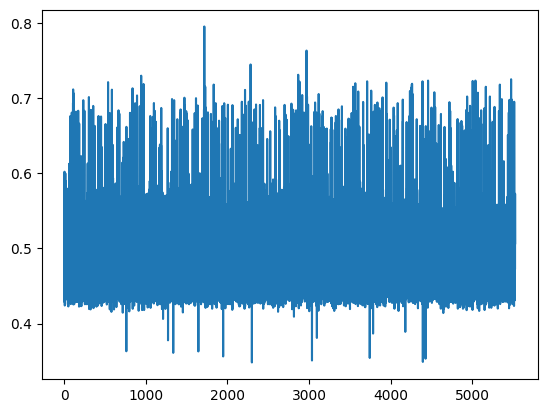

In [113]:
import matplotlib.pyplot as plt
plt.plot(y_pred_stats_valid)
plt.show()

In [61]:
x_train_stats.shape, x_valid_stats.shape, X.shape

((22114, 16), (5529, 16), (27643,))

In [57]:
train_score = roc_auc_score(Y_train, y_pred_stats_train)
valid_score = roc_auc_score(Y_valid, y_pred_stats_valid)
train_score, valid_score

(0.6236394324847986, 0.49056547237407844)

In [21]:
print(clf.predict_proba(X_valid)[:,1])

NameError: name 'clf' is not defined

In [41]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score

clf = SGDClassifier(loss='log_loss', alpha=0.01, max_iter=100, tol=1e-3)

In [106]:
valid_score = roc_auc_score(y_valid, clf.predict_proba(tfidf.transform(X_valid))[:,1])
print(f'Valid score: {valid_score}')

Valid score: 0.5480487324200225


In [103]:
print(clf.predict_proba(tfidf.transform(X_train[:10]))[:10,1])

[0.49059807 0.49510801 0.49422455 0.49326543 0.49163678 0.49724253
 0.50165794 0.49173992 0.49409215 0.49771022]


### Prediction

In [137]:
df = pd.read_csv('./datasets/test.csv')
print("Content:\n",df.loc[0])

Id = df.loc[:, 'Id'].to_numpy()
X_test = df.loc[:, 'Page content'].to_numpy()
print(X_test.shape)
print("\nId:\n", Id[0])
print("Content:\n", X_test[0])

Content:
 Id                                                          27643
Page content    <html><head><div class="article-info"><span cl...
Name: 0, dtype: object
(11847,)

Id:
 27643
Content:
 <html><head><div class="article-info"><span class="byline "><a href="/author/sam-laird/"><img alt="2016%2f09%2f15%2f63%2fhttpsd2mhye01h4nj2n.cloudfront.netmediazgkymde1lza2.9814b" class="author_image" src="http://i.amz.mshcdn.com/-qaMPB8aiQeIaoBhqlU0OLjA07A=/90x90/2016%2F09%2F15%2F63%2Fhttpsd2mhye01h4nj2n.cloudfront.netmediaZgkyMDE1LzA2.9814b.jpg"/></a><span class="author_name">By <a href="/author/sam-laird/">Sam Laird</a></span><time datetime="Mon, 09 Sep 2013 19:47:02 +0000">2013-09-09 19:47:02 UTC</time></span></div></head><body><h1 class="title">Soccer Star Gets Twitter Death Threats After Tackling One Direction Member</h1><figure class="article-image"></figure><article data-channel="entertainment"><section class="article-content"> <div class="shift-to-hero"> <p><iframe allowfullscreen="" 

In [138]:
y_pred = model.predict_proba(feature_selection_part2(X_test, False))[:,1]
print(y_pred.shape)
print(y_pred[0])

(11847,)
0.43565327


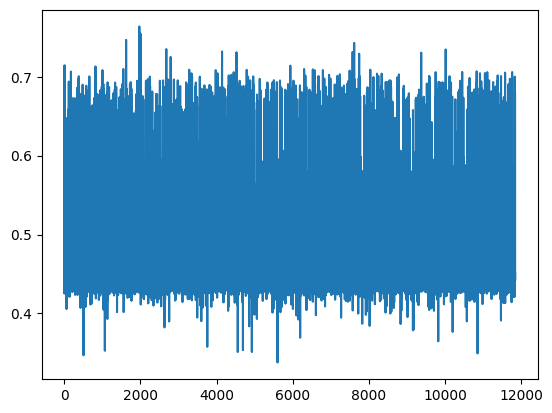

In [139]:
#plot dot
import matplotlib.pyplot as plt
plt.plot(y_pred)
plt.show()

In [140]:
output_data = {'Id': Id, 'Popularity': y_pred}
output_dataframe = pd.DataFrame(output_data)
print(output_dataframe)

output_dataframe.to_csv("./datasets/y_pred.csv", index=None)

          Id  Popularity
0      27643    0.435653
1      27644    0.460360
2      27645    0.425238
3      27646    0.526979
4      27647    0.499779
...      ...         ...
11842  39485    0.680619
11843  39486    0.517602
11844  39487    0.512882
11845  39488    0.441743
11846  39489    0.450606

[11847 rows x 2 columns]


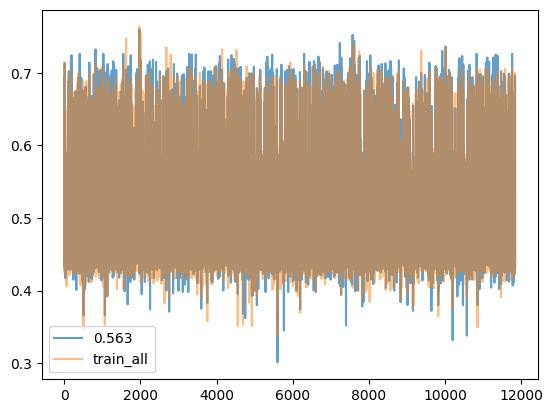

In [160]:
df = pd.read_csv('./datasets/y_pred_563.csv')
a = df['Popularity']
df = pd.read_csv('./datasets/y_pred_570.csv')
b = df['Popularity']
df = pd.read_csv('./datasets/y_pred_0255.csv')
# c = y_pred
d = y_pred
df = pd.read_csv('./datasets/y_pred_big.csv')
e = df['Popularity']
import matplotlib.pyplot as plt
plt.plot(a, label='0.563', alpha=0.7)
# plt.plot(b, label='0.570', alpha=0.7)
# plt.plot(c, label='train0.8', alpha=0.7)
plt.plot(d, label='train_all', alpha=0.5)
# plt.plot(e, label='big', alpha=0.5)
plt.legend()
plt.show()


| train score | valid score | public score | Method              |
|:--------- | --------- |:------------ | ------------------- |
| 0.701   | 0.561   | 0.544      | Feature Hashing + SGDClassifier |
| 0.857 | 0.548 |        | Info word + Feature Hashing + XGBClassifier <br> Info num + GradientBoostingClassifier <br> Content + TFIDF +RandomForestClassifier <br> Proportion: 0, 0.4, 0.6|
| 0.769 |	0.567 |        | Info word + Feature Hashing + SGDClassifier <br>Info num + GradientBoostingClassifier <br>Content + TFIDF +RandomForestClassifier <br> Proportion: 0.45, 0.1925, 0.3575 |
| 0.888   | 0.576   | 0.550      |  Info word + Feature Hashing + RandomForestClassifier<br>Info num + RandomForestClassifier<br>Content + TFIDF +RandomForestClassifier<br>Proportion: 0.4, 0.27, 0.33 |
| 0.857 | 0.548 |        | TFIDF + LogisticRegression |
| 0.627 | 0.553 |        | TFIDF + SGDClassifier      |
|0.911  |0.546  |        | TFIDF + XGBClassifier      |
|0.713  | 0.558 |        | TFIDF + RndomForestClassifier                           |
| 0.817   | 0.569   | 0.552      | TF-IDF + xgboost + GradientBoostingClassifier |
| 0.591   | 0.584   | 0.562      |  Feature_selection_part2 + XGBClassifier |